In [11]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")  
from openai import OpenAI
import re
from typing import Optional
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()
import csv

In [12]:
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [ ]:
ACTIVITY = 'activity'
DEVICE = 'device'
START_TIME = 'start_time'
END_TIME = 'end_time'
TIME = 'time'
VALUE = 'value'
NAME = 'name'

DATASET ='A'
DATA_DIR = 'best_predict_A'

# Initialize DeepSeek client
# api_key = DEEPSEEK_API_KEY  # Your DeepSeek API Key
# client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
# model_name = "deepseek-chat"
# MODEL="deepseek"

api_key = OPENAI_API_KEY
client = OpenAI(api_key=api_key)
model_name="gpt-4o-mini-2024-07-18"
MODEL="gpt-4o-mini"
temperature=0


In [14]:
from data_load.load_data import load_ordoneza_dataset_nochange
from pathlib import Path

dataset_b = load_ordoneza_dataset_nochange(Path("../dataset/UCI_ADL_Binary"), part=DATASET)
print(dataset_b['activities'].head())
print(dataset_b['devices'].head())
print(dataset_b.keys())
print(dataset_b['activity_list'])

           start_time            end_time             activity
0 2011-11-28 02:27:59 2011-11-28 10:18:11             sleeping
2 2011-11-28 10:25:44 2011-11-28 10:33:00            showering
3 2011-11-28 10:34:23 2011-11-28 10:43:00  preparing breakfast
4 2011-11-28 10:49:48 2011-11-28 10:51:13        personal care
5 2011-11-28 10:51:41 2011-11-28 13:05:07    relaxing on couch
           start_time            end_time location      type     place  \
0 2011-11-28 02:27:59 2011-11-28 10:18:11      Bed  Pressure   Bedroom   
1 2011-11-28 10:21:24 2011-11-28 10:21:31  Cabinet  Magnetic  Bathroom   
2 2011-11-28 10:21:44 2011-11-28 10:23:31    Basin       PIR  Bathroom   
3 2011-11-28 10:23:02 2011-11-28 10:23:36   Toilet     Flush  Bathroom   
4 2011-11-28 10:25:44 2011-11-28 10:32:06   Shower       PIR  Bathroom   

                      device  
0       Bedroom_Bed_Pressure  
1  Bathroom_Cabinet_Magnetic  
2         Bathroom_Basin_PIR  
3      Bathroom_Toilet_Flush  
4        Bathroom_Show

In [8]:
from data_process.preprocess import convert_events_to_states

state_df = convert_events_to_states(dataset_b['devices'], DATASET)
print(state_df)
# state_df.head(40)

                                             state          start_time  \
0            st(Bedroom-BedOccupied, 02:27, 10:18) 2011-11-28 02:27:59   
1       st(Bathroom-CabinetDoorOpen, 10:21, 10:21) 2011-11-28 10:21:24   
2     st(Bathroom-NearBathroomBasin, 10:21, 10:23) 2011-11-28 10:21:44   
3           st(Bathroom-ToiletFlush, 10:23, 10:23) 2011-11-28 10:23:02   
4    st(Bathroom-NearBathroomShower, 10:25, 10:32) 2011-11-28 10:25:44   
..                                             ...                 ...   
404       st(Kitchen-FridgeDoorOpen, 15:13, 15:13) 2011-12-11 15:13:52   
405         st(Bathroom-ToiletFlush, 15:29, 15:30) 2011-12-11 15:29:03   
406   st(Bathroom-NearBathroomBasin, 15:41, 15:43) 2011-12-11 15:41:34   
407          st(Living-SeatOccupied, 15:43, 00:22) 2011-12-11 15:43:51   
408          st(Bedroom-BedOccupied, 00:31, 07:22) 2011-12-12 00:31:35   

               end_time location      type     place  \
0   2011-11-28 10:18:11      Bed  Pressure   Bedroom   

In [9]:
def segment_by_labeled_activity(sensor_df, activity_df):
    windows_list = []
    activities_list = []
    
    required_columns = ['state', 'start_time', 'end_time', 'location', 'type', 'place', 'device']
    assert all(col in sensor_df.columns for col in required_columns), "Sensor DataFrame missing required columns"
    
    for _, activity_row in activity_df.iterrows():
        window = sensor_df[
            (sensor_df['start_time'] <= activity_row['end_time']) & 
            (sensor_df['end_time'] >= activity_row['start_time'])
        ].copy()
        
        if not window.empty:
            window_events = window.apply(
                lambda row: {
                    'state': row['state'],
                    'start_time': row['start_time'],
                    'end_time': row['end_time'],
                    'location': row['location'],
                    'type': row['type'],
                    'place': row['place'],
                    'device': row['device']
                }, 
                axis=1
            ).tolist()
            
            windows_list.append(window_events)
            activities_list.append(activity_row['activity'])
    
    return windows_list, activities_list

windows, activities = segment_by_labeled_activity(state_df, dataset_b['activities'])

print("Windows:")
for i, window in enumerate(windows):
    print(f"Window {i + 1} (Activity: {activities[i]}):")
    for event in window:
        print(f"  {event}")
print("\nActivities:", activities)

Windows:
Window 1 (Activity: sleeping):
  {'state': 'st(Bedroom-BedOccupied, 02:27, 10:18)', 'start_time': Timestamp('2011-11-28 02:27:59'), 'end_time': Timestamp('2011-11-28 10:18:11'), 'location': 'Bed', 'type': 'Pressure', 'place': 'Bedroom', 'device': 'Bedroom_Bed_Pressure'}
Window 2 (Activity: showering):
  {'state': 'st(Bathroom-NearBathroomShower, 10:25, 10:32)', 'start_time': Timestamp('2011-11-28 10:25:44'), 'end_time': Timestamp('2011-11-28 10:32:06'), 'location': 'Shower', 'type': 'PIR', 'place': 'Bathroom', 'device': 'Bathroom_Shower_PIR'}
Window 3 (Activity: preparing breakfast):
  {'state': 'st(Kitchen-FridgeDoorOpen, 10:34, 10:34)', 'start_time': Timestamp('2011-11-28 10:34:23'), 'end_time': Timestamp('2011-11-28 10:34:41'), 'location': 'Fridge', 'type': 'Magnetic', 'place': 'Kitchen', 'device': 'Kitchen_Fridge_Magnetic'}
  {'state': 'st(Kitchen-CupboardDoorOpen, 10:34, 10:37)', 'start_time': Timestamp('2011-11-28 10:34:44'), 'end_time': Timestamp('2011-11-28 10:37:17'),

In [10]:
def save_results(windows, activities, output_dir=f'{DATA_DIR}/windows', activities_file=f'{DATA_DIR}/truth_labels.txt'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with open(activities_file, 'w') as f:
        for activity in activities:
            f.write(f"{activity}\n")
    
    fieldnames = ['state', 'start_time', 'end_time', 'location', 'type', 'place', 'device']
    for i, window in enumerate(windows, 1):
        window_file = os.path.join(output_dir, f'window_{i}.csv')
        with open(window_file, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(window)

save_results(windows, activities)
print("Data has been saved to files.")

Data has been saved to files.


In [15]:
from utils.tools import load_dataframes_from_files

loaded_dataframes = load_dataframes_from_files(f"{DATA_DIR}/windows")

if loaded_dataframes:
    for i, df in enumerate(loaded_dataframes):
        if i < 5:
            print(f"DataFrame {i + 1}:")
            print(df.head())
            print("-" * 20)
        else:
            break

DataFrame 1:
                                   state           start_time  \
0  st(Bedroom-BedOccupied, 02:27, 10:18)  2011-11-28 02:27:59   

              end_time location      type    place                device  
0  2011-11-28 10:18:11      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure  
--------------------
DataFrame 2:
                                           state           start_time  \
0  st(Bathroom-NearBathroomShower, 10:25, 10:32)  2011-11-28 10:25:44   

              end_time location type     place               device  
0  2011-11-28 10:32:06   Shower  PIR  Bathroom  Bathroom_Shower_PIR  
--------------------
DataFrame 3:
                                        state           start_time  \
0    st(Kitchen-FridgeDoorOpen, 10:34, 10:34)  2011-11-28 10:34:23   
1  st(Kitchen-CupboardDoorOpen, 10:34, 10:37)  2011-11-28 10:34:44   
2         st(Kitchen-ToasterOn, 10:38, 10:42)  2011-11-28 10:38:00   
3    st(Kitchen-FridgeDoorOpen, 10:38, 10:38)  2011-11-28 10:38:33   
4


    The data comes from an event-based time window starting around 2:27 AM.
    Here is the list of recorded events:
    [{'state': 'Bedroom-BedOccupied', 'place': 'bedroom', 'duration': 28212, 'start_time': '2:27 AM', 'end_time': '10:18 AM'}]
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around 2:27 AM, ".
    - Indicate the subject's location and describe their activities based on the state, place, and device information.
    - Use connecting words (like "then", "while", or "after") to make the description flow smoothly.
    - Incorporate approximate times (start_time) where relevant to provide a sense of sequence.
    
Window 1:
Description: Around 2:27 AM, the subject was in the bedroom, where they occupied the bed for an extended period. They remained there until approximately 10:18 AM, suggesting a restful night of sleep.
Classified Activity: sleeping
Description Time: 6.58s, Tokens: 241
Classificatio

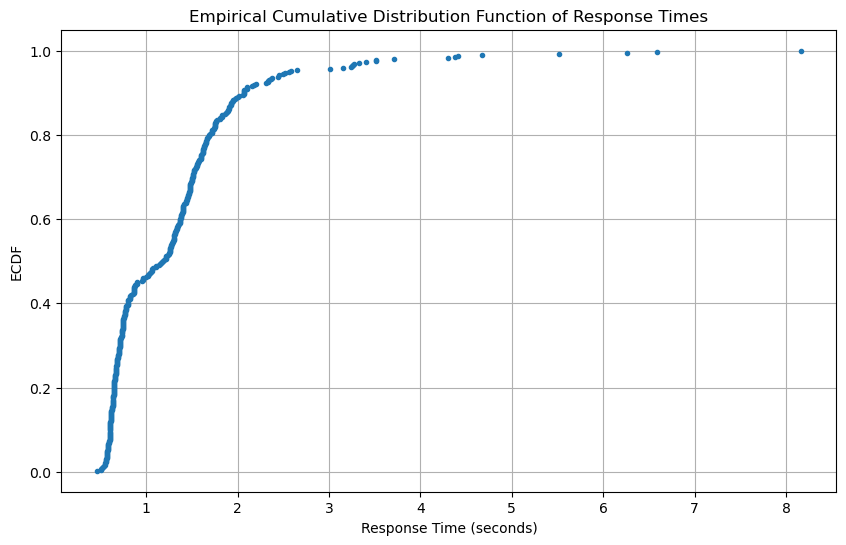

ECDF plot saved to: best_predict_A_/response_time_ecdf.png


In [ ]:
import pandas as pd
from datetime import timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
import re
import os

# Function 1: Generate natural language descriptions with token and time tracking
def generate_natural_language_description(df):
    """
    Convert sensor state data into a natural language description using LLM.
    Tracks token usage and response time. Adapted for event-based windows without activity column.
    """
    # 确保时间列是 datetime 类型
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # 获取窗口的起始和结束时间
    window_start = df['start_time'].min()
    window_end = df['end_time'].max()
    window_time_str = window_start.strftime('%I:%M %p').lstrip('0')
    
    # 按开始时间排序
    df = df.sort_values('start_time')
    
    # 生成事件列表
    events = []
    for _, row in df.iterrows():
        # 从 state 中提取状态名称 (e.g., Kitchen-FridgeDoorOpen)
        state_name = row['state'].split('(')[1].split(',')[0] if '(' in row['state'] else row['state']
        duration = (row['end_time'] - row['start_time']).total_seconds()
        event = {
            'state': state_name,
            'place': row['place'].lower(),
            # 'location': row['location'].lower(),
            # 'type': row['type'].lower(),
            # 'device': row['device'].lower(),
            'duration': int(duration) if duration > 0 else 1,
            'start_time': row['start_time'].strftime('%I:%M %p').lstrip('0'),
            'end_time': row['end_time'].strftime('%I:%M %p').lstrip('0')
        }
        events.append(event)
    
    prompt = f"""
    The data comes from an event-based time window starting around {window_time_str}.
    Here is the list of recorded events:
    {events}
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around {window_time_str}, ".
    - Indicate the subject's location and describe their activities based on the state, place, and device information.
    - Use connecting words (like "then", "while", or "after") to make the description flow smoothly.
    - Incorporate approximate times (start_time) where relevant to provide a sense of sequence.
    """

    print(prompt)
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a helpful intelligent assistant tasked with converting sensor data into smooth, natural English descriptions"},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        return {
            'description': response.choices[0].message.content.strip(),
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'description': f"Error generating description: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Function 2: Classify a single description with token and time tracking
def classify_single_activity(description):
    system_prompt = """
    Act as a human activity recognition system that infers the activities performed by a subject in their home.
    The home has the following locations: 'bathroom', 'bedroom', 'kitchen', and 'living room', and 'entrance (main door)'
    The system captures the subject's interactions with: Shower, Basin, Cooktop, Maindoor, Fridge, Cabinet, Cupboard, Toilet, Microwave, Seat, Bed, Toaster.
    I will provide you with a description of what happened during a specific time window, and your goal is to provide the most likely activity.
    The possible activities are following: sleeping,showering,preparing breakfast,personal care,relaxing on couch,leaving home,preparing lunch,snacking
    Your answer should be only one activity using the following format: ACTIVITY=(activity name)
    """
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": description}
            ],
            stream=False,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        activity_str = response.choices[0].message.content.strip()
        activity_label = extract_activity_label(activity_str)
        
        return {
            'activity': activity_label if activity_label else "Unknown",
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'activity': f"Error: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Helper function to extract activity label
def extract_activity_label(response: str) -> Optional[str]:
    """Extract the activity label from the model response."""
    match = re.search(r"ACTIVITY=(.*)", response)
    if match:
        return match.group(1).strip()
    return None

# Modified pipeline execution with tracking and ECDF plotting
def run_pipeline(windows, desc_output_path=f'best_predict_A/descriptions_{DATASET}.txt', 
                 label_output_path=f'best_predict_A/predictions_{DATASET}.txt',
                 metrics_output_path=f'best_predict_A/metrics_{DATASET}.txt'):
    """
    Run the pipeline: generate description, classify it, track metrics, and plot ECDF of response times.
    """
    os.makedirs(os.path.dirname(desc_output_path), exist_ok=True)
    
    response_times = []
    total_tokens = 0
    all_tokens = []

    with open(desc_output_path, 'w', encoding='utf-8') as desc_file, \
         open(label_output_path, 'w', encoding='utf-8') as label_file, \
         open(metrics_output_path, 'w', encoding='utf-8') as metrics_file:
        
        for idx, window in enumerate(windows):
            # Step 1: Generate description
            desc_result = generate_natural_language_description(window)
            description = desc_result['description']
            desc_time = desc_result['response_time']
            desc_tokens = desc_result['tokens_used']
            
            # Step 2: Classify the description
            class_result = classify_single_activity(description)
            activity_label = class_result['activity']
            class_time = class_result['response_time']
            class_tokens = class_result['tokens_used']
            
            # Track metrics
            response_times.extend([desc_time, class_time])
            total_tokens += desc_tokens + class_tokens
            all_tokens.extend([desc_tokens, class_tokens])

            # Print results
            print(f"Window {idx + 1}:")
            print(f"Description: {description}")
            print(f"Classified Activity: {activity_label}")
            print(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}")
            print(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n")
            
            # Save to files
            desc_file.write(f"{description}\n")
            label_file.write(f"{activity_label}\n")
            metrics_file.write(f"Window {idx + 1}:\n")
            metrics_file.write(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}\n")
            metrics_file.write(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n\n")

        print(f"\nTotal windows processed: {len(windows)}")
        print(f"Total tokens used: {total_tokens}")
        print(f"Descriptions saved to: {desc_output_path}")
        print(f"Activity labels saved to: {label_output_path}")
        print(f"Metrics saved to: {metrics_output_path}") # 添加了metrics的保存路径输出

        # Save all tokens to the metrics file
        # metrics_file.write("\nAll tokens used (description, classification):\n")
        # for tokens in all_tokens:
        #     metrics_file.write(f"{tokens}\n")

    # Generate and plot ECDF
    plot_ecdf(response_times)

def plot_ecdf(response_times):
    """Generate and display ECDF plot of response times."""
    sorted_times = np.sort(response_times)
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, y, marker='.', linestyle='none')
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function of Response Times')
    plt.grid(True)
    
    # Save plot
    plot_path = f'best_predict_A/response_time_ecdf.png'
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.show()
    print(f"ECDF plot saved to: {plot_path}")

# Run the pipeline
test = loaded_dataframes.copy()
run_pipeline(test)

In [24]:
from evaluation.evaluator import evaluate_predictions_split_activities

evaluate_predictions_split_activities(DATA_DIR, DATASET, f"{DATA_DIR}/truth_labels.txt", 
                                      f"{DATA_DIR}/predictions_A.txt",
                                      f"{DATA_DIR}/evaluation.txt")

True labels file: best_predict_A_/truth_labels.txt
Predicted labels file: best_predict_A_/predictions_A.txt
Output file: best_predict_A_/evaluation.txt


d:\Users\thesis-exp\activity_window_based\..\evaluation\evaluator.py:54: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Evaluation results saved to best_predict_A_/evaluation.txt
Comprehensive confusion matrix saved to best_predict_A_\confusion_matrix_all_activities.png
Micro-F1 Score (Global): 0.9412
Macro-F1 Score (Class Average): 0.8011
Weighted F1 Score (Weighted Average): 0.9457
Sample-average F1 Score (Sample Average): 0.9412
Mean Jaccard Similarity: 0.9412
